# CS170 Project Notebook

### Imports

In [1]:
import networkx as nx
from parse import read_input_file, write_input_file, write_output_file
from utils import is_valid_network, average_pairwise_distance, average_pairwise_distance_fast
import sys

import matplotlib.pyplot as plt
%matplotlib inline
import random

import solver
from solver import EmployedBee

## Generate Inputs

In [2]:
def randomNGraph(n: int):
    temp = nx.generators.random_graphs.erdos_renyi_graph(n, 5/n)
    while not nx.is_connected(temp):
        temp = nx.generators.random_graphs.erdos_renyi_graph(n, 5/n)

    for (u, v) in temp.edges():
        temp.edges[u, v]['weight'] = round(random.uniform(1/n, n), 2)
    return temp


## Create input files

In [3]:
G25 = randomNGraph(25)
G50 = randomNGraph(50)
G100 = randomNGraph(100)

In [4]:
write_input_file(G25, "./25.in")
write_input_file(G50, "./50.in")
write_input_file(G100, "./100.in")

## Algorithm

### Artificial Bee Colony Algorithms

- Initialisation
   - Each scout bee generates a random connected dominating tree and becomes employed bee. 

- Iteration
   - Each employed bee calls `find_neighbor` to try to find a solution toward its local optimum. 
   - Each onlooker bee randomly chooses two employed bee and choose the bee whose solution has lower cost. The one chosen is called `find_neighbor` again.  
   - If an employed bee solution is not improved over time (e.g. 10 times or so), fire the bee (let the bee find a new solution from scratch). 

- Final Decision
   - Choose an employed bee with lower cost. 

In [7]:
def cost(T, G):
    assert(is_valid_network(G, T))
    return average_pairwise_distance_fast(T)

#### Unit Tests: Test if `random_dominating_tree` (scout) is valid

In [8]:
def testRandomDominatingTree(iterations: int, sub_iterations: int):
    for i in range(iterations):
        r = randomNGraph(100)
        costs = []
        for _ in range(sub_iterations):
            rd = solver.randomDominatingTree(r)
            assert(is_valid_network(r, rd))
            costs.append(round(average_pairwise_distance_fast(rd), 2))
        print("At iteration %d: Initial Costs: %s" % (i, str(costs)))
    print("TEST PASSED: All results are valid network. ")


In [5]:
solver.RANDOMIZED_WEIGHT_VARIATION = 0.3
testRandomDominatingTree(10, 10)

NameError: name 'testRandomDominatingTree' is not defined

In [9]:
bee = EmployedBee(G25)

In [11]:
cost(bee.solution, G25)

39.40246666666667

In [81]:
bee.work()

False

In [82]:
cost(bee.solution, G25)

31.09619047619048

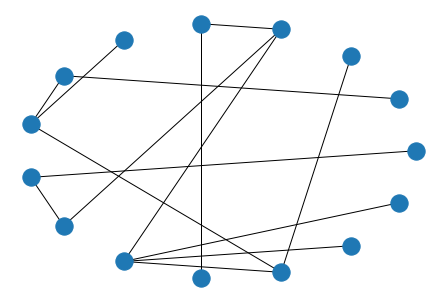

In [83]:
nx.draw_shell(bee.solution)